# Landcover Classification

* **Products used:** 
[cci_landcover](https://explorer.digitalearth.africa/products/cci_landcover)

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell.

### Load packages

In [1]:
%matplotlib inline

import datacube
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import geopandas as gpd

import matplotlib.ticker as mticker

from deafrica_tools.plotting import plot_lulc, map_shapefile, xr_animation
from deafrica_tools.spatial import xr_rasterize

### Connect to the datacube

In [2]:
dc = datacube.Datacube(app="Landcover_classification")

In [3]:
gdf = gpd.read_file('../Real_world_examples/african_countries.geojson')

In [4]:
gdf = gdf.drop_duplicates('CODE')

In [5]:
country_name = 'Burkina Faso'
gdf_selected = gdf.where(gdf["COUNTRY"] == country_name)
# Get the bounding box of the country.
bbox = list(gdf_selected.total_bounds)

# From the bounding box get the area of interest.
lon_range = (bbox[0], bbox[2])
lat_range = (bbox[1], bbox[3])

In [6]:
#IPCC Classification
ipcc_classess = ['Forest', 'Cropland', 'Grassland', 'Wetland', 'Other land', 'Settlement']
ipcc_classess_num = [1, 2, 3, 4, 5, 6]
def ipcc_classification(ds, measurements):
    ds_clas = ds[measurements]
    #IPCC Classification
    forest = [50, 60, 61, 62, 70, 71, 72, 80, 81, 82, 90, 100]
    cropland = [10, 11, 12, 20, 30, 110]
    grassland = [40, 120, 121, 122, 130, 140]
    wetland = [160, 170, 180]
    otherland = [150, 151, 152, 153, 200, 201, 202, 210, 220]
    settlement = [190]

    ipcc_condition = [ds_clas.isin(forest),
                      ds_clas.isin(cropland),
                      ds_clas.isin(grassland),
                      ds_clas.isin(wetland),
                      ds_clas.isin(otherland),
                      ds_clas.isin(settlement)]

    result = xr.DataArray(np.select(ipcc_condition, ipcc_classess_num),
                                                 coords={"time": ds.time, "y": ds.y, "x": ds.x},
                                                 dims=["time", "y", "x"]).astype("int8")
    
    return result.where(result > 0)


## Load the LULC datasets

In [7]:
#create reusable datacube query object
measurements = 'classification'
time_1 = '2000'
time_2 = '2010'
time_3 = '2019'

query = {
    "x": lon_range,
    "y": lat_range,
    'resolution':(-300, 300),
    'output_crs': 'epsg:6933',
    'measurements': measurements
}

#load the data
ds_year_1 = dc.load(product='cci_landcover',time=(time_1), **query)
ds_year_2 = dc.load(product='cci_landcover',time=(time_2), **query)
ds_year_3 = dc.load(product='cci_landcover',time=(time_3), **query)
mask = xr_rasterize(gdf[gdf["COUNTRY"] == country_name], ds_year_3)
ds_year_1 = ds_year_1.where(mask)
ds_year_2 = ds_year_2.where(mask)
ds_year_3 = ds_year_3.where(mask)

In [8]:
ds_year_1 = ipcc_classification(ds_year_1, measurements)
ds_year_2 = ipcc_classification(ds_year_2, measurements)
ds_year_3 = ipcc_classification(ds_year_3, measurements)

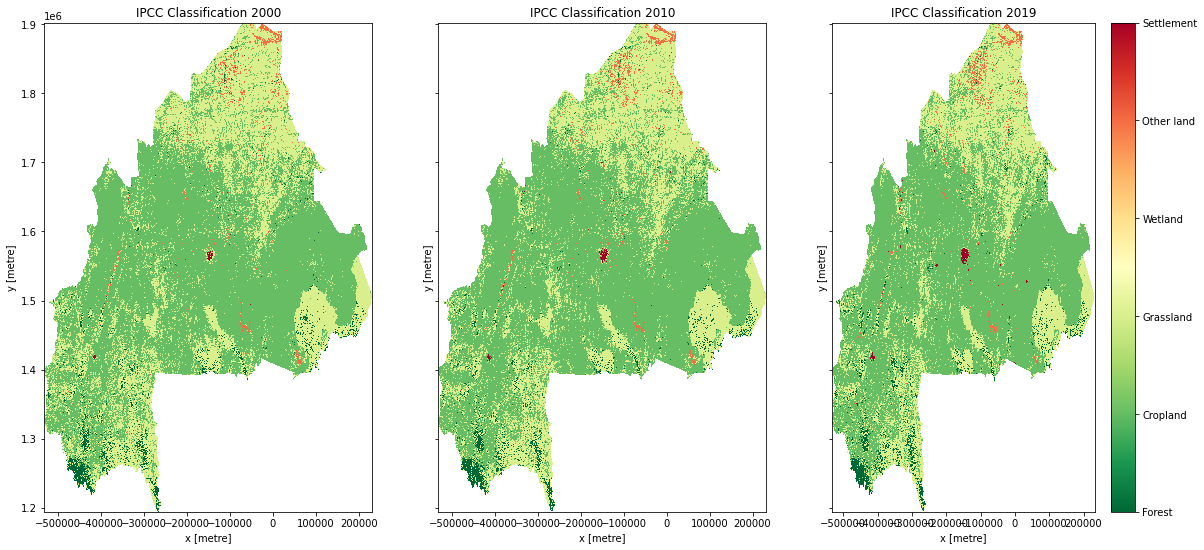

In [9]:
fig,ax = plt.subplots(1,3, figsize=(20,9), sharey=True)

ds_year_1.plot(add_colorbar=False, cmap="RdYlGn_r" ,ax=ax[0])
ax[0].set_title(f"IPCC Classification {time_1}")


ds_year_2.plot(add_colorbar=False, cmap="RdYlGn_r",ax=ax[1])
ax[1].set_title(f"IPCC Classification {time_2}")


clas = ds_year_3.plot(add_colorbar=False, cmap="RdYlGn_r",ax=ax[2])
clasp = plt.colorbar(clas)
clasp.set_ticks(ipcc_classess_num)
clasp.set_ticklabels(ipcc_classess)
ax[2].set_title(f"IPCC Classification {time_3}")
plt.show()

### Calculate the area of each class

We can use the numpy `np.unique` function to return the pixel count for each class.

In [10]:
ds_counts_year_1 = np.unique(ds_year_1.values, return_counts=True)
ds_counts_year_2 = np.unique(ds_year_2.values, return_counts=True)
ds_counts_year_3 = np.unique(ds_year_3.values, return_counts=True)

In [11]:
pixel_length = query["resolution"][1]  # in metres, refers to resolution we defined above (-10,10) for Antananarivo
m_per_km = 1000  # conversion from metres to kilometres
area_per_pixel = pixel_length**2 / m_per_km**2

#calculate the area of each class
ds_year_1_area = np.array(ds_counts_year_1[1] * area_per_pixel)
ds_year_2_area = np.array(ds_counts_year_2[1] * area_per_pixel)
ds_year_3_area = np.array(ds_counts_year_3[1] * area_per_pixel)

/tmp/ipykernel_581/1340954486.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(ipcc_classess, rotation=90)
/tmp/ipykernel_581/1340954486.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(ipcc_classess, rotation=90)
/tmp/ipykernel_581/1340954486.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[2].set_xticklabels(ipcc_classess, rotation=90)


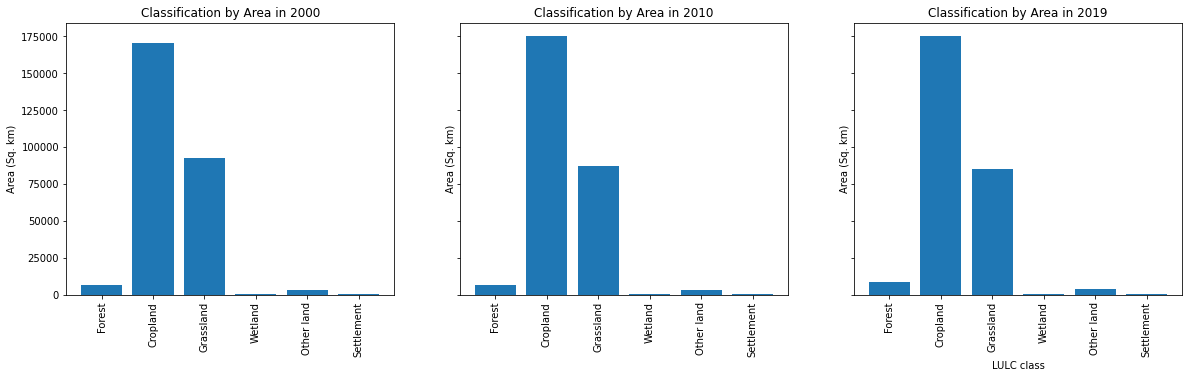

In [12]:
fig,ax = plt.subplots(1, 3, figsize=(20, 5), sharey = True)

#plot cci
ax[0].bar(x = ipcc_classess, height = ds_year_1_area[:-1])
ax[0].set_xticklabels(ipcc_classess, rotation=90)
ax[0].set_ylabel("Area (Sq. km)")
ax[0].set_title(f"Classification by Area in {time_1}")

ax[1].bar(x = ipcc_classess, height = ds_year_2_area[:-1])
ax[1].set_xticklabels(ipcc_classess, rotation=90)
ax[1].set_ylabel("Area (Sq. km)")
ax[1].set_title(f"Classification by Area in {time_2}")

ax[2].bar(x = ipcc_classess, height = ds_year_3_area[:-1])
ax[2].set_xticklabels(ipcc_classess, rotation=90)
ax[2].set_ylabel("Area (Sq. km)")
ax[2].set_xlabel("LULC class")
ax[2].set_title(f"Classification by Area in {time_3}")

plt.show()

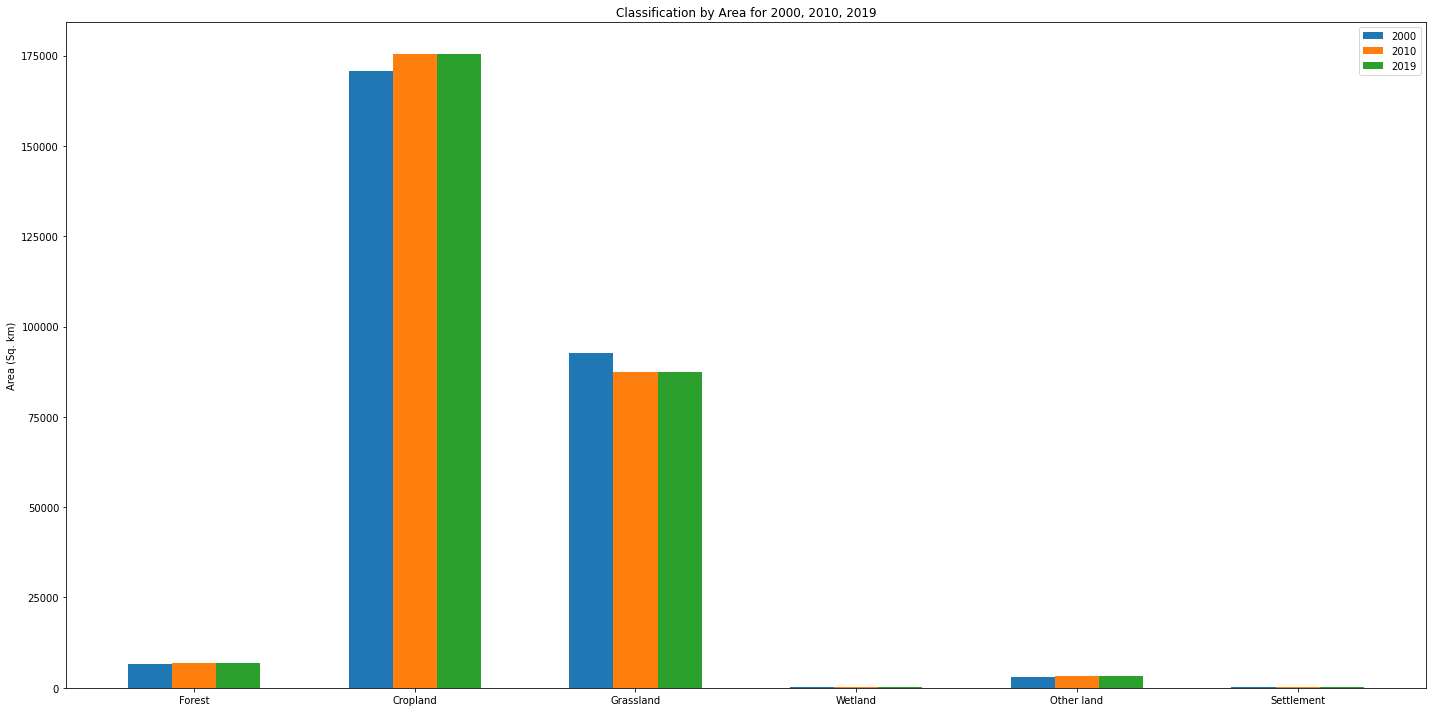

In [13]:
x = np.arange(len(ipcc_classess))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(20, 10))

#plot cci
plt.bar(x - width, ds_year_1_area[:-1], width, label=time_1)
plt.bar(x, ds_year_2_area[:-1], width, label=time_2)
plt.bar(x + width, ds_year_2_area[:-1], width, label=time_3)

plt.xticks(x, ipcc_classess)

plt.ylabel("Area (Sq. km)")
plt.title(f"Classification by Area for {time_1}, {time_2}, {time_3}")
plt.legend()

fig.tight_layout()

In [14]:
data = {
    time_1: ds_year_1_area[:-1],
    time_2: ds_year_2_area[:-1],
    time_3: ds_year_3_area[:-1]
}

df = pd.DataFrame(data, index=ipcc_classess)

df

,2000,2010,2019
Forest,6688.35,6844.68,8440.74
Cropland,170763.93,175418.91,175255.20
Grassland,92574.00,87317.28,84973.32
Wetland,259.11,261.45,257.58
Other land,2891.70,3216.78,3844.44
Settlement,195.30,313.29,601.11


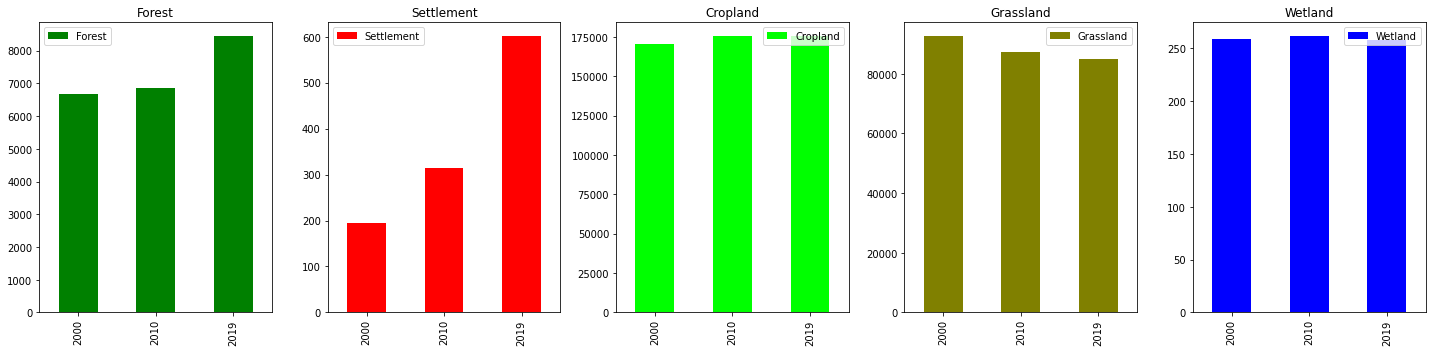

In [15]:
fig,ax = plt.subplots(1, 5, figsize=(20, 5))
df.iloc[0].plot(kind='bar', label=ipcc_classess[0], color='Green', ax=ax[0])
ax[0].legend()
ax[0].set_title(ipcc_classess[0])

df.iloc[5].plot(kind='bar', label=ipcc_classess[5], color='Red', ax=ax[1])
ax[1].legend()
ax[1].set_title(ipcc_classess[5])

df.iloc[1].plot(kind='bar', label=ipcc_classess[1], color='lime', ax=ax[2])
ax[2].legend()
ax[2].set_title(ipcc_classess[1])

df.iloc[2].plot(kind='bar', label=ipcc_classess[2], color='olive', ax=ax[3])
ax[3].legend()
ax[3].set_title(ipcc_classess[2])

df.iloc[3].plot(kind='bar', label=ipcc_classess[3], color='Blue', ax=ax[4])
ax[4].legend()
ax[4].set_title(ipcc_classess[3])

plt.tight_layout()


In [16]:
ds_year_1.name = 'LULC'
ds_year_2.name = 'LULC'
ds_year_3.name = 'LULC'

In [17]:
ds = xr.merge([ds_year_1, ds_year_2, ds_year_3])

Exporting animation to LULC.gif


  0%|          | 0/3 (0.0 seconds remaining at ? frames/s)

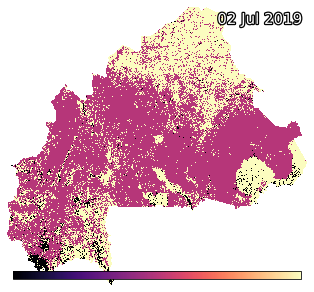

In [18]:
out_path = 'LULC.gif'

xr_animation(ds=ds, 
             output_path=out_path,
             interval=1000,
             bands=['LULC'], 
             width_pixels=300,
             annotation_kwargs={'fontsize': 15}) 

---

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:**

In [19]:
print(datacube.__version__)

1.8.6


**Last tested:**

In [20]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2022-07-07'